# Статистический анализ: A/B тестирование

## Введение

В этом проекте мы проведём полный цикл A/B тестирования на реальных данных.  
Цель — проверить, есть ли статистически значимое различие в конверсии между двумя группами пользователей:

- **control** — контрольная группа, видит старую страницу  
- **treatment** — экспериментальная группа, видит новую страницу

Датасет содержит следующие поля:

- `user_id` — уникальный идентификатор пользователя  
- `timestamp` — время посещения  
- `group` — группа (control/treatment)  
- `landing_page` — версия страницы (old_page/new_page)  
- `converted` — факт конверсии (0/1)

Мы проверим гипотезу:  
- H0: конверсия в обеих группах одинаковая  
- H1: конверсии различаются

---

## Импорт библиотек

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.power import NormalIndPower
import scikits.bootstrap as boot

## Загрузка данных

Загрузим данные из CSV-файла и посмотрим на первые строки.

In [106]:
df = pd.read_csv('ab_data.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


## Информация о данных

Посмотрим общую информацию и проверим размер датасета.

In [107]:
df.info()
print(f"Размер датасета: {df.shape[0]} строк")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       294478 non-null  int64         
 1   timestamp     294478 non-null  datetime64[ns]
 2   group         294478 non-null  object        
 3   landing_page  294478 non-null  object        
 4   converted     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB
Размер датасета: 294478 строк


In [108]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

## Очистка данных

Найдём количество пользователей, у которых наблюдается несоответствие в распределении страниц: пользователи из тестовой группы (treatment) не видят новую страницу, а пользователи из контрольной группы видят новую страницу.

In [109]:
df[(df['group'] == 'treatment') & (df['landing_page'] != 'new_page')].count().iloc[0] + \
df[(df['group'] != 'treatment') & (df['landing_page'] == 'new_page')].count().iloc[0]

np.int64(3893)

Удаляем строки с некорректным распределением пользователей по страницам:
1. Пользователи из группы 'treatment' не должны видеть старую страницу (landing_page != 'new_page'),
2. Пользователи из 'control' не должны видеть новую страницу (landing_page == 'new_page').

In [110]:
df.drop(df[(df['group'] == 'treatment') & (df['landing_page'] != 'new_page')].index, inplace=True)
df.drop(df[(df['group'] != 'treatment') & (df['landing_page'] == 'new_page')].index, inplace=True)
df.shape

(290585, 5)

Находим все строки с дублирующимися пользователями по столбцу 'user_id'

In [111]:
df[df['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Удалим дублирующиеся строки

In [112]:
df.drop(df[df['user_id'].duplicated()].index, inplace=True)

## Разведочный анализ данных (EDA)

In [113]:
summary = df.groupby('group').agg(
    n_users=('user_id','count'),
    conversions=('converted','sum')
)

In [114]:
summary

,n_users,conversions
group,,
control,145274,17489
treatment,145310,17264


In [115]:
summary['conversion_rate'] = summary['conversions'] / summary['n_users']

In [116]:
summary

,n_users,conversions,conversion_rate
group,,,
control,145274,17489,0.120386
treatment,145310,17264,0.118808


In [117]:
alpha = 0.05
z = stats.norm.ppf(1 - alpha/2)
summary['ci_half'] = z * np.sqrt(summary['conversion_rate'] * (1 - summary['conversion_rate']) / summary['n_users'])
summary['ci_lower'] = summary['conversion_rate'] - summary['ci_half']
summary['ci_upper'] = summary['conversion_rate'] + summary['ci_half']

In [118]:
summary

,n_users,conversions,conversion_rate,ci_half,ci_lower,ci_upper
group,,,,,,
control,145274,17489,0.120386,0.001673,0.118713,0.122060
treatment,145310,17264,0.118808,0.001664,0.117144,0.120472


**Вывод по результатам разведочного анализа данных (EDA):**

В контрольной группе средняя конверсия составила примерно 12.04% (95% доверительный интервал: 11.87% – 12.21%), а в тестовой группе — около 11.88% (95% доверительный интервал: 11.71% – 12.05%). Доверительные интервалы перекрываются, что указывает на отсутствие явной статистически значимой разницы между группами.

Это означает, что на данном этапе нет убедительных доказательств того, что новая версиястраницы (тестовая группа) существенно влияет на уровень конверсии по сравнению со старой версией (контрольная группа).

Для более точного заключения необходимо провести проверку гипотез с использованием статистического теста для сравнения конверсий в двух группах. Результаты этого теста позволят определить, является ли наблюдаемая разница статистически значимой.

## Проверка гипотез

Проверим нулевую гипотезу, что конверсии в обеих группах равны, с помощью Z-теста для пропорций.  
Также проведём χ²-тест как альтернативу.

In [120]:
count = summary['conversions'].values
nobs = summary['n_users'].values
z_stat,p_value = proportions_ztest(count, nobs)
print(f"Z-тест: z = {z_stat:.3f}, p-value = {p_value:.5f}")

Z-тест: z = 1.311, p-value = 0.18988


In [121]:
contingency_table = np.array([
    summary['conversions'].values,
    summary['n_users'].values - summary['conversions'].values
])
chi2_stat, chi2_p, dof, expected = stats.chi2_contingency(contingency_table.T)
print(f"Chi2-тест: chi2 = {chi2_stat:.3f}, p-value = {chi2_p:.5f}")

Chi2-тест: chi2 = 1.704, p-value = 0.19182


**Результаты проверки гипотез:**

При проведении Z-теста для разности пропорций получили значение статистики z = 1.311 и p-value = 0.18988.

Аналогично, при использовании Chi2-теста статистика составила chi2 = 1.704 с p-value = 0.19182.

Оба теста дают p-value значительно выше уровня значимости 0.05, что означает недостаток оснований отвергать нулевую гипотезу о равенстве конверсий в контрольной и тестовой группах.

Таким образом, на основании имеющихся данных нельзя утверждать о статистически значимом отличии между конверсиями на старой и новой посадочных страницах. Это говорит о том, что новая версия не показала значимого улучшения конверсии по сравнению со старой.

## Бутстрэп-оценка разницы конверсий

Для большей уверенности проведём бутстрэп-оценку разницы конверсий и её доверительного интервала.

In [122]:
control = df[df['group'] == 'control']['converted'].values
treatment = df[df['group'] == 'treatment']['converted'].values

def bootstrap_diff(control, treatment, n_bootstrap=10000):
    boot_diffs = []
    n_control = len(control)
    n_treatment = len(treatment)

    for _ in range(n_bootstrap):
        control_sample = np.random.choice(control, size=n_control, replace=True)
        treatment_sample = np.random.choice(treatment, size=n_treatment, replace=True)
        diff = np.mean(treatment_sample) - np.mean(control_sample)
        boot_diffs.append(diff)

    return np.array(boot_diffs)

boot_diffs = bootstrap_diff(control, treatment)

mean_diff = np.mean(treatment) - np.mean(control)
ci_lower = np.percentile(boot_diffs, 2.5)
ci_upper = np.percentile(boot_diffs, 97.5)

print(f"Средняя разница конверсий: {mean_diff:.4f}")
print(f"95% доверительный интервал (бутстрэп): [{ci_lower:.4f}, {ci_upper:.4f}]")

Средняя разница конверсий: -0.0016
95% доверительный интервал (бутстрэп): [-0.0040, 0.0008]


**Результаты бутстрэпинга:**

Средняя разница конверсий между тестовой и контрольной группами составила примерно -0.0016 (то есть конверсия в тестовой группе немного ниже).
95% доверительный интервал, построенный с помощью бутстрэп-метода, равен от -0.0040 до 0.0008.

Поскольку доверительный интервал включает ноль, это дополнительно подтверждает отсутствие статистически значимой разницы между группами.

**Визуализации доверительного интервала для разницы конверсий**

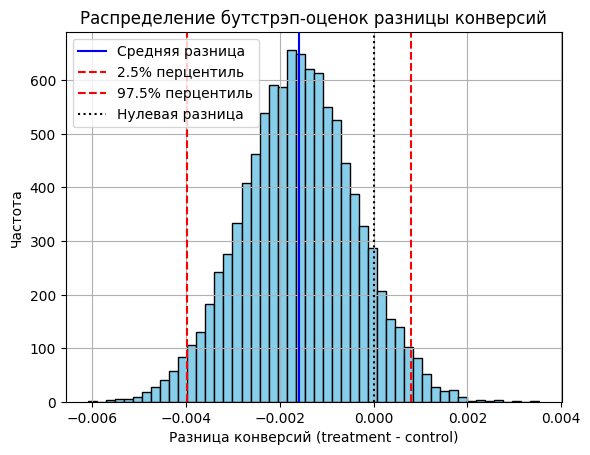

In [125]:
plt.hist(boot_diffs, bins=50, color='skyblue', edgecolor='k')
plt.axvline(mean_diff, color='blue', label='Средняя разница')
plt.axvline(ci_lower, color='red', linestyle='--', label='2.5% перцентиль')
plt.axvline(ci_upper, color='red', linestyle='--', label='97.5% перцентиль')
plt.axvline(0, color='black', linestyle=':', label='Нулевая разница')
plt.legend()
plt.title('Распределение бутстрэп-оценок разницы конверсий')
plt.xlabel('Разница конверсий (treatment - control)')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

## Power-анализ

Рассчитаем минимальный размер выборки для обнаружения эффекта с мощностью 0.8 и уровнем значимости 0.05.

In [126]:
control = df[df['group'] == 'control']['converted'].values
treatment = df[df['group'] == 'treatment']['converted'].values

p1 = control.mean()
p2 = treatment.mean()

effect_size = proportion_effectsize(p2, p1)


alpha = 0.05
power = 0.8

analysis = NormalIndPower()

sample_size_per_group = analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha, alternative='two-sided')

print(f'Нужный размер выборки на группу для обнаружения разницы: {int(np.ceil(sample_size_per_group))}')

Нужный размер выборки на группу для обнаружения разницы: 663574


**Результаты анализа мощности (power-анализ):**

Для того чтобы с надежностью обнаружить имеющуюся разницу в конверсии между группами с уровнем значимости 0.05 и мощностью теста 80%, необходим минимальный размер выборки на каждую группу составляет примерно 663 574 пользователей.

Это значительно больше текущего объема данных, что объясняет отсутствие статистически значимой разницы — имеющиеся выборки слишком малы для уверенного выявления такого эффекта.

## Вывод

Проведённый анализ A/B-теста показал, что текущие данные не содержат статистически значимых отличий в конверсии между контрольной (старой страницей) и тестовой (новой страницей) группами. Средняя разница конверсий небольшая и отрицательная (-0.16%), а доверительные интервалы, построенные бутстрэпом, включают ноль, что указывает на отсутствие эффекта.

Проверка гипотез с помощью Z-теста и Chi2-теста подтвердила это — полученные p-value значительно выше стандартного уровня значимости 0.05, что не позволяет отвергнуть нулевую гипотезу о равенстве конверсий.

Кроме того, power-анализ показал, что для надёжного обнаружения такой разницы требуется существенно больше данных — порядка 660 тысяч пользователей на каждую группу. Текущие размеры выборок значительно меньше этого порога, что объясняет отсутствие статистической значимости.

Таким образом, на основании имеющихся данных можно сделать вывод, что новая версия посадочной страницы не демонстрирует улучшения конверсии по сравнению с существующей. Для более точного решения по внедрению рекомендуется либо увеличить размер выборки, либо рассмотреть другие метрики и подходы.